# Data Exploration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("NQ_from_2000.csv", sep= ";")

In [4]:
df.head()

,Date,Time,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
0,01/03/2000,01:00,6975.5,6977.0,6975.5,6975.5,3,0,0.0,0.0
1,01/03/2000,02:00,6977.5,6979.5,6977.5,6979.5,2,0,-1.0,-1.0
2,01/03/2000,03:00,6979.5,6993.5,6979.5,6987.5,21,0,-1.0,-1.0
3,01/03/2000,04:00,6986.5,6994.5,6984.5,6992.5,16,0,-1.0,-1.0
4,01/03/2000,05:00,6994.5,6999.5,6993.5,6999.5,19,0,-1.0,-1.0


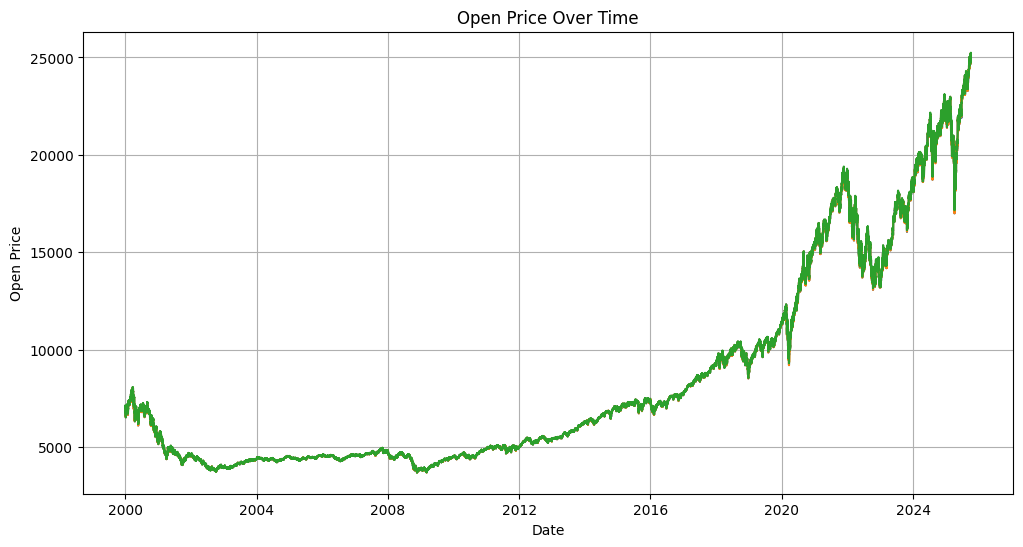

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'])
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['High'])
plt.title('Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()

In [ ]:
High_low_delta = np.mean(df["High"] - df["Low"])
High_low_delta 

np.float64(20.215157563803075)

In [10]:
High_low_delta = np.mean(df["Open"] - df["Close"])
High_low_delta 

np.float64(-0.12723588455867998)

# Quant Strat 

## Hypothesis

We assume
- Instant trade
- No fees on trades
- We can buy any percentage of the stock
- No impact on market
- No arbitrage


## 1.Benchmark

Time in the market beats timing in the market 

The benchmark buys 100 $ of the index fund each first of the month at 12

In [17]:
# Filter data
benchmark_trades = df[(df['Time'] == '12:00') & (df['Date'].dt.day == 1)]

# Calculate the performance
benchmark_returns = []
investment = 0
units = 0

for _, trade in benchmark_trades.iterrows():
    # Buy 1 unit at the open price
    units += 100 / trade["Open"] 
    investment +=  100
    
# Calculate final value using the last close price
final_value = units * df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100
PnL = (final_value - investment)

print(f"Total investment: ${investment:,.2f}")

print(f"Final value: ${final_value:,.2f}")
print(f"PnL : ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total investment: $19,900.00
Final value: $78,233.12
PnL : $58,333.12
Total return: 293.13%


## 2. Dummy strategy